In [1]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [2]:
path = r'../../CSV'

# the below function verifies that the dataframe you are working with is the same shape as the anticipated dataframe
def test_dataframe_shape():
    # load the dataframe to be tested
    with open(f'{path}/dynamic_rollover.pkl', 'rb') as file:
        df = pickle.load(file)
    # Perform the shape validation
    # assert df.shape == (258905, 118)
    return df

# working dataframe that has 'Label', 'Dynamic Rollover', 'LOW-G' as the final 3 columns
df = test_dataframe_shape().reset_index(drop=True)


In [3]:
X = df.drop('Dynamic Rollover', axis=1)
y = df['Dynamic Rollover']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# y_test: 
# Dynamic Rollover
# 0    51270
# 1      511
# Name: count, dtype: int64

params = {
    'rf__n_estimators': [200],  # 100, 200
    'rf__max_depth': [None],  # 5, 10
    'rf__min_samples_split': [2],  # 5, 10
    'rf__min_samples_leaf': [1],  # 2, 4
    'rf__max_features': ['log2'],  # 'sqrt'
    'rf__bootstrap': [False],  # False
    'rf__class_weight': ['balanced'],
    'rf__random_state': [42],
    'rf__n_jobs': [-1]
}

# create a pipeline
pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])

f1_scorer = make_scorer(f1_score)
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=strat_k_fold, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             param_grid={'rf__bootstrap': [False],
                         'rf__class_weight': ['balanced'],
                         'rf__max_depth': [None], 'rf__max_features': ['log2'],
                         'rf__min_samples_leaf': [1],
                         'rf__min_samples_split': [2],
                         'rf__n_estimators': [200], 'rf__n_jobs': [-1],
                         'rf__random_state': [42]},
             scoring=make_scorer(f1_score))

In [5]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_  

y_pred = best_model.predict(X_test)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [7]:
from sklearn.metrics import make_scorer, recall_score

In [8]:
recall_scorer = make_scorer(recall_score, average='weighted')

In [9]:
# Create learning curve data using learning_curve function with recall scoring
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring=recall_scorer, train_sizes=np.linspace(0.1, 1.0, 10)
)

In [10]:
# Calculate mean and standard deviation for training and cross-validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

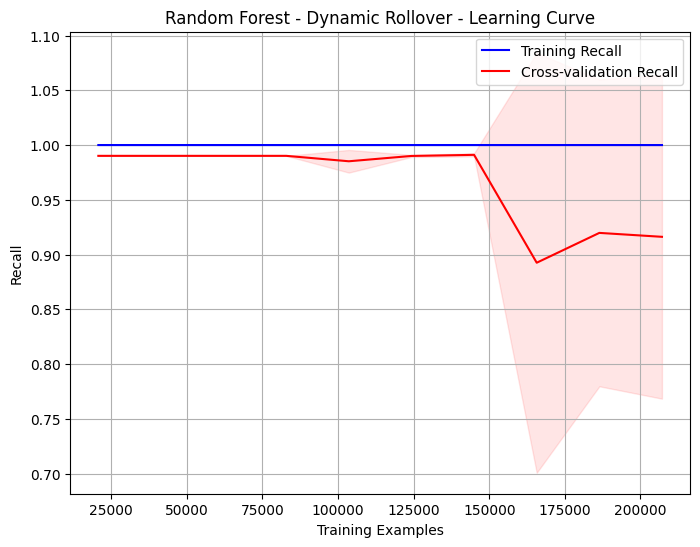

In [11]:
# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Recall', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation Recall', color='red')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='red')

plt.title('Random Forest - Dynamic Rollover - Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.grid()
plt.show()

Most important variables:
Altitude(MSL): 0.13677521857315977
Roll: 0.04288178644714054
Yaw Acceleration: 0.08763573591649475
Altitude(AGL): 0.1259256041542172
Roll Rate: 0.03772277413378339
Roll Acceleration: 0.12384875223219956
Collective Pos-[0]: 0.010291695427094783
Pitch Acceleration: 0.12149699561681251
Rotor Torque-[0]: 0.0
Pitch Rate: 0.0365694458366391
Cyclic Pitch Pos-[0]: 0.024023224600683412
Gross Weight: 0.025183260848163202
Wind Speed(True): 0.029632153359450672
Groundspeed: 0.03186505781217571
Pitch: 0.04128339416698641
Yaw: 0.039931343314246144
Sideslip Angle: 0.02629547841914004
Yaw Rate: 0.03577941368027163
Pedal Pos: 0.0
Cyclic Roll Pos-[0]: 0.022858665461341066


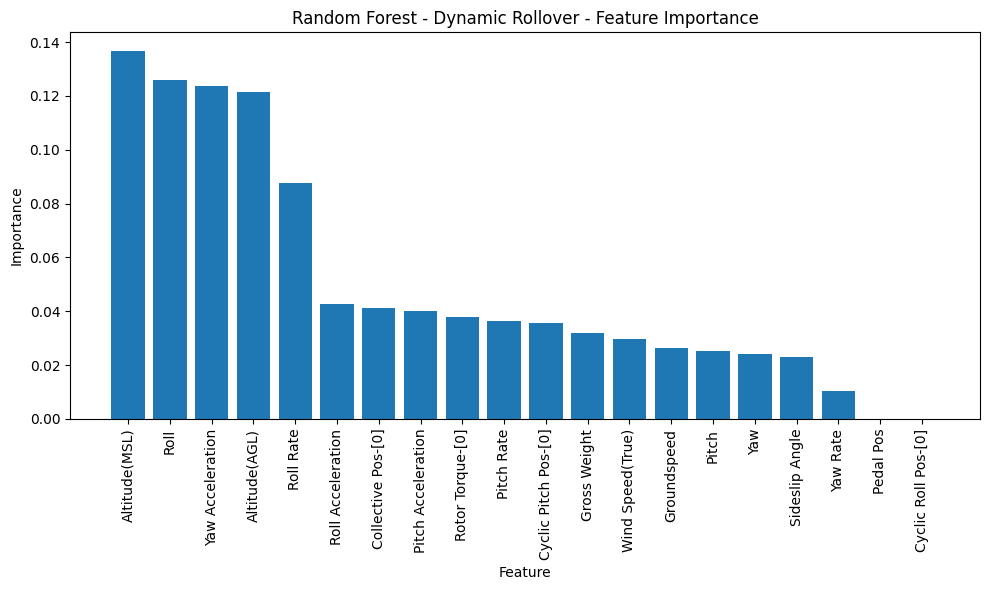

In [12]:
# Create a recall scoring function for use during training
recall_scorer = make_scorer(recall_score, average='weighted')

rf_model = best_model.named_steps['rf']
feature_importances = rf_model.feature_importances_

# Train the model on the entire dataset
best_model.fit(X, y)

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]

# Retrieve feature names
feature_names = list(X_train.columns)

# Print the most important variables
print("Most important variables:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {sorted_feature_importances[i]}")
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_feature_importances, align='center')
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest - Dynamic Rollover - Feature Importance')
plt.tight_layout()
plt.show()

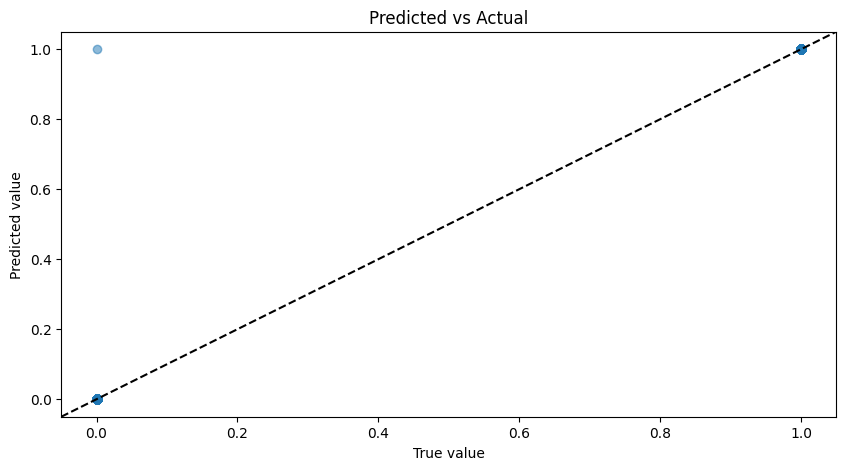

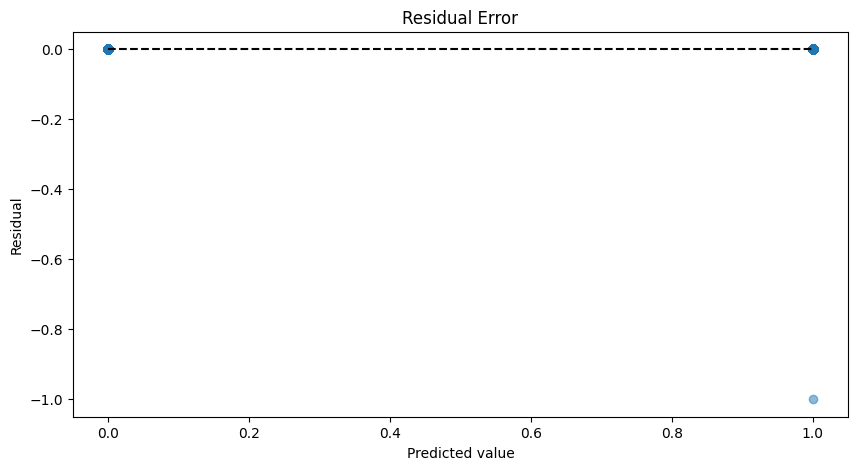

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predicted values using the best model
y_pred = grid_search.predict(X_test)

# Plot predicted vs actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Predicted vs Actual')
plt.show()

# Plot residual errors
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, xmin=min(y_pred), xmax=max(y_pred), colors='k', linestyles='--')
plt.xlabel('Predicted value')
plt.ylabel('Residual')
plt.title('Residual Error')
plt.show()
